# Developping a framework for the centralised controller of a Brittle Star robot
Integrating the brittle star morphology and environment framework of the bio-inspired robotics benchmark with the Evosac implementations of neural networks.

In [1]:
import sys

print(sys.executable)

/user/gent/457/vsc45787/.conda/envs/hope/bin/python


In [53]:
import numpy as np
import jax
from jax import numpy as jnp
import evosax
from evosax import OpenES, ParameterReshaper, NetworkMapper, FitnessShaper
import flax
from flax import linen as nn
from typing import Any, Callable, Sequence, Union, List
import biorobot
import time
import matplotlib.pyplot as plt

import wandb
print(wandb.__path__)
%env "WANDB_NOTEBOOK_NAME" "Centralized controller framework"
# import moviepy
import imageio
import plotly

rng = jax.random.PRNGKey(0) # make an rng right away and every split throughout the document should make a new rng
# this new rng should only be used for the sole purpose of splitting in the future


['/user/gent/457/vsc45787/.conda/envs/hope/lib/python3.11/site-packages/wandb']
env: "WANDB_NOTEBOOK_NAME"="Centralized controller framework"


## Checking accesibility GPU

In [3]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl
    xla_flags = os.environ.get('XLA_FLAGS', '')
    xla_flags += ' --xla_gpu_triton_gemm_any=True'
    os.environ['XLA_FLAGS'] = xla_flags

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Tue Mar  5 09:39:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   49C    P0              17W /  60W |  11248MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining classes and functionalities

### Utilities for visualisation

In [4]:
from moojoco.environment.base import MuJoCoEnvironmentConfiguration
from moojoco.mjcf.component import MJCFRootComponent

# Graphics and plotting.
ffmpeg_v = !command -v ffmpeg
assert "command not found" not in ffmpeg_v, f"Please install FFmpeg for visualizations."
!{sys.executable} -m pip install -q mediapy
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
jnp.set_printoptions(precision=3, suppress=True, linewidth=100)


def visualize_mjcf(
        mjcf: MJCFRootComponent
        ) -> None:
    model = mujoco.MjModel.from_xml_string(mjcf.get_mjcf_str())
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None]
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379).")
    return media.show_video(images=filtered_images)

### Utilities for generating neural network

In [5]:
# build NN architecture
class ExplicitMLP(nn.Module):
    features: Sequence[int]
    joint_control: str 
    # act_hidden: Callable = nn.tanh,
    # act_output: Callable = nn.tanh

    """
    features: number of outputs (# nodes) for each layer. The number of inputs of the first layer defined by the call function.
    The number of inputs of the hidden layers and output layer defined by the number of outputs of the previous layer.
    act_hidden: activation function applied to hidden layers: popular is nn.tanh or nn.relu
    act_output: activation function applied to output layer: popular is nn.tanh or nn.sigmoid
    joint_control: should be either 'position' or 'torque', depending on what control strategy the morphology was initialised with
    """

    def setup(
        self
    ):
        """
        Fully connected neural network, characterised by a pytree (dict containing dict with params and biases)
        Features represents the number of outputs of the Dense layer
        inputs based on the presented input later on
        after presenting input: kernel can be generated
        """
        self.layers = [nn.Dense(feat) for feat in self.features]



    def __call__(
        self,
        inputs,
        act_hidden: Callable = nn.tanh,
        act_output: Callable = nn.tanh
    ):
        """
        Returning the output of a layer for a given input.
        Don't directly call an instance of ExplicitMLP --> this method is called in the apply method.
        -----
        
        """
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = act_hidden(x)
            else:
                assert self.joint_control in ['position', 'torque'], "joint_control should be either 'position' or 'torque'"
                if self.joint_control == 'position':
                    x = 30*jnp.pi/180 * act_output(x) # the action space range for positions is -0.5236..0.5236
                elif self.joint_control == 'control':
                    x = act_output(x) # the action space range for torques is -1..1
        return x

### Utilities for defining the Brittle Star Environment

In [6]:
# Creating morphology
import gymnasium
from biorobot.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from biorobot.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from biorobot.brittle_star.mjcf.morphology.specification.specification import BrittleStarMorphologySpecification

def create_morphology(
        morphology_specification: BrittleStarMorphologySpecification
        ) -> MJCFBrittleStarMorphology:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    return morphology


In [7]:
# Creating arena
from biorobot.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

def create_arena(
        arena_configuration: AquariumArenaConfiguration
        ) -> MJCFAquariumArena:
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    return arena

In [8]:
# Creating environment
from biorobot.brittle_star.environment.light_escape.shared import BrittleStarLightEscapeEnvironmentConfiguration
from biorobot.brittle_star.environment.directed_locomotion.shared import \
    BrittleStarDirectedLocomotionEnvironmentConfiguration
from biorobot.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration


from biorobot.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from biorobot.brittle_star.environment.directed_locomotion.dual import BrittleStarDirectedLocomotionEnvironment
from biorobot.brittle_star.environment.light_escape.dual import BrittleStarLightEscapeEnvironment
from moojoco.environment.dual import DualMuJoCoEnvironment
from moojoco.environment.base import MuJoCoEnvironmentConfiguration


def create_environment(
        morphology_specification: BrittleStarMorphologySpecification,
        arena_configuration: AquariumArenaConfiguration,
        environment_configuration: MuJoCoEnvironmentConfiguration,
        backend: str
        ) -> DualMuJoCoEnvironment:
    assert backend in ["MJC", "MJX"], "Please specify a valid backend; Either 'MJC' or 'MJX'"

    morphology = create_morphology(
            morphology_specification=morphology_specification
            )
    arena = create_arena(
            arena_configuration=arena_configuration
            )
    if isinstance(environment_configuration, BrittleStarUndirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarUndirectedLocomotionEnvironment
    elif isinstance(environment_configuration, BrittleStarDirectedLocomotionEnvironmentConfiguration):
        env_class = BrittleStarDirectedLocomotionEnvironment
    else:
        env_class = BrittleStarLightEscapeEnvironment

    env = env_class.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend=backend
            )
    return env

### Definition of the rollout function

In [9]:
def rollout(policy_params_shaped, total_num_control_timesteps, sensor_selection, rng, NUM_MJX_ENVIRONMENTS):
    """
    Do a single episode rollout
    Inputs:
    - Reshaped policy params to match neural network
    - Total_num_control_timesteps
    - sensor selection
    - rng
    - Total number of parallel MJX environments
    Outpus:
    - Final MJX environment state (vectorized)
    - Rewards: sum of all rewards of every timestep
    - rng
    """
    # add and return 'rng' param?
    rng, mjx_vectorized_env_rng = jax.random.split(rng, 2)
    mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS))
    mjx_vectorized_state_reset = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)
    
    carry_init = [mjx_vectorized_state_reset, policy_params_shaped]

    def step(carry, xs):
        """
        Carry: any information required in the carryover:
        - vectorized state array for the mujoco steps
        - shaped pytree with policy params for the model.apply
        - sensor_selection (is not updated over carries, but is required for doing correct observations)
        -----
        xs is not required for this purpose, but put in the arguments as a placeholder for jax.lax.scan to function.
        -----
        output:
        - Carry: state to be updated, and the same policy_params en sensor_selection passed on to the next generation
        """    

        _mjx_vectorized_state, _policy_params_shaped = carry

        _sensory_input_nn = jnp.concatenate(
            [_mjx_vectorized_state.observations[label] for label in sensor_selection],
            axis = 1
        )
            
        # # below: if you want to select all the observations
        # _sensory_input_nn = jnp.concatenate(
        #     jax.tree_util.tree_map(_mjx_vectorized_state.observations.__getitem__, list(_mjx_vectorized_state.observations.keys())),
        #     axis = 1
        # )
        
        
        _action = vectorized_model_apply(_policy_params_shaped, _sensory_input_nn)
        
        _mjx_vectorized_state_updated = mjx_vectorized_step(state=_mjx_vectorized_state, action=_action)
        
        reward_step = _mjx_vectorized_state_updated.reward

        carry = [_mjx_vectorized_state_updated, _policy_params_shaped]
        return carry, reward_step

    final_carry, stack = jax.lax.scan(
        step,
        carry_init,
        None,
        total_num_control_timesteps
    )

    rewards = stack
    
    mjx_vectorized_state_final = final_carry[0]
    return mjx_vectorized_state_final, rewards, rng

rollout = jax.jit(rollout, static_argnames=("total_num_control_timesteps", "NUM_MJX_ENVIRONMENTS", "sensor_selection"))

## Generating instances

### Instantiating the morphology specification, arena configuration and environment configuration

Number of actuator outputs: dofs =  20


""

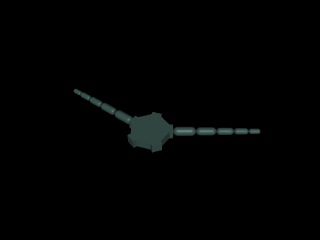

""

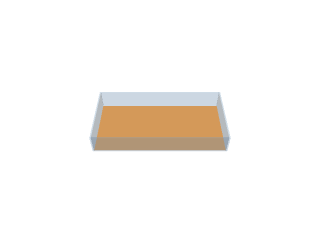

[simulation_time] The total amount of time (in seconds) that one simulation episode takes: 5
[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: 0.004
[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: 0.04
[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: 1250
[total_num_control_steps] The total amount of control steps that happen during one simulation episode: 125


In [11]:
arm_setup = [5,0,5,0,0] # 2 arms with 5 segments
dofs = 2*sum(arm_setup)
print("Number of actuator outputs: dofs = ", dofs)



reward_type = "distance" # choose "distance", "target", "light"
joint_control = "position" # choose "position" or "torque"
sand_ground_color = True # choose True or False, False allows for seeing movement with respect to grid lines.
num_physics_steps_per_control_step=10 
simulation_time=5 # [seconds]
joint_randomization_noise_scale=0.0
light_perlin_noise_scale=4 # default: take 0 for no noise, take max of 200, take integer factor of 200
# If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities


# specifying morphology
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=len(arm_setup), num_segments_per_arm=arm_setup, use_p_control=(joint_control == 'position'), use_torque_control=(joint_control == 'torque')
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)


# specifying arena
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=sand_ground_color, attach_target=(reward_type=="target"), wall_height=1.5, wall_thickness=0.1
        )
arena = create_arena(arena_configuration=arena_configuration)
visualize_mjcf(mjcf=arena)


# specifying environment: CHOOSE 1
assert reward_type in (["distance","target","light"]), "reward_type must be one of 'distance', 'target', 'light'"

if reward_type == "distance":
    environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        # If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities 
        joint_randomization_noise_scale=joint_randomization_noise_scale,
        render_mode="rgb_array",  # Visualization mode 
        simulation_time=simulation_time,  # Number of seconds per episode 
        num_physics_steps_per_control_step=num_physics_steps_per_control_step,  # Number of physics substeps to do per control step 
        time_scale=2,    # Integer factor by which to multiply the original physics timestep of 0.002,
        camera_ids=[0, 1],   # Which camera's to render (all the brittle star environments contain 2 cameras: 1 top-down camera and one close-up camera that follows the brittle star),
        render_size=(480, 640)  # Resolution to render with ((height, width) in pixels)
        )

elif reward_type == "target":
    environment_configuration = BrittleStarDirectedLocomotionEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=joint_randomization_noise_scale,
        render_mode="rgb_array",
        simulation_time=simulation_time,
        num_physics_steps_per_control_step=num_physics_steps_per_control_step,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

elif reward_type == "light":
    environment_configuration = BrittleStarLightEscapeEnvironmentConfiguration(
        joint_randomization_noise_scale=joint_randomization_noise_scale,
        light_perlin_noise_scale=light_perlin_noise_scale,
        # If this value is > 0, we will add perlin noise to the generated light map. Otherwise, the light map is a simple linear gradient.
        # Please only provide integer factors of 200.
        render_mode="rgb_array",
        simulation_time=simulation_time,
        num_physics_steps_per_control_step=num_physics_steps_per_control_step,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )

BACKEND = "MJX"

# useful environment configuration information
print(f"[simulation_time] The total amount of time (in seconds) that one simulation episode takes: {environment_configuration.simulation_time}")
print(f"[physics_timestep] The amount of time (in seconds) that one 'physics step' advances the physics: {environment_configuration.physics_timestep}")
print(f"[control_timestep] The amount of time (in seconds) that one 'control step' advances the physics: {environment_configuration.control_timestep}")
print(f"[total_num_physics_steps] The total amount of physics steps that happen during one simulation episode: {environment_configuration.total_num_physics_steps}")
print(f"[total_num_control_steps] The total amount of control steps that happen during one simulation episode: {environment_configuration.total_num_control_steps}")


total_num_control_timesteps = environment_configuration.total_num_control_steps

### Example of environment instance to try things wrt observation and action space

""

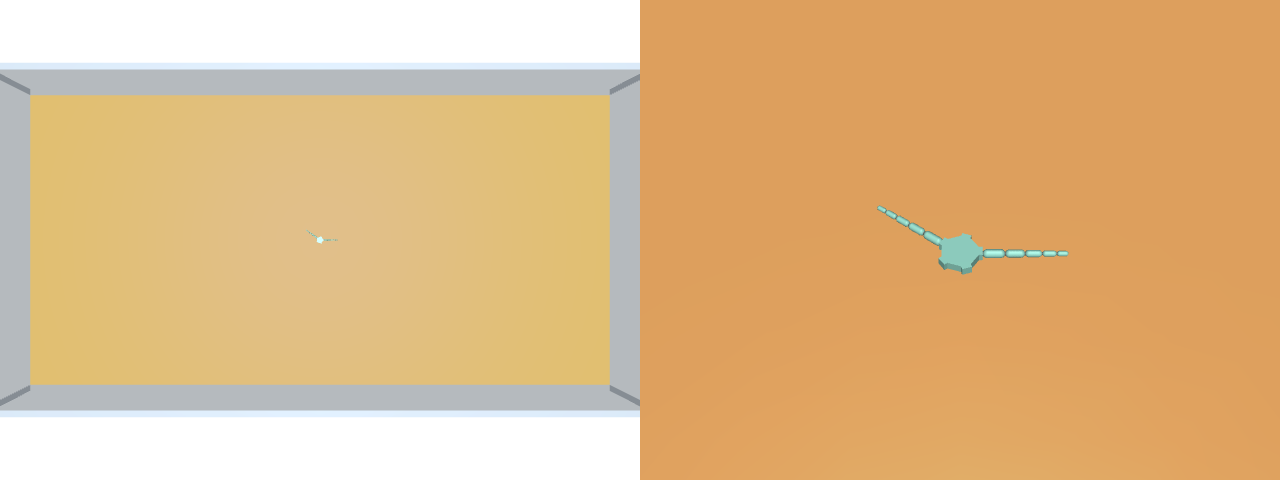

In [12]:
env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend=BACKEND
        )



if BACKEND == "MJC":
    rng = np.random.RandomState(0)
else:
    rng = jax.random.PRNGKey(seed=0)

state = env.reset(rng=rng)  # Always need to reset the environment before doing anything else with it
frame = env.render(state=state)
media.show_image(post_render(render_output=frame, environment_configuration=environment_configuration))


In [13]:
print("MJX Observatin Space:")
print(f"\t{env.observation_space}")

print("MJX Action Space:")
print(f"\t{env.action_space}")

print("First 5 actuators:")
print(f"\tMJX: {env.actuators[:5]}")


MJX Observatin Space:
	Dict('joint_position': Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (10,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))
MJX Action Space:
	Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>)
First 5 actuators:
	MJX: ['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_1_out_of_plane_joint_p_contr

In [14]:
print(state.observations)
sensors = [key for key in state.observations.keys()]
sensors_with_dim = {s: len(d) for s, d in state.observations.items()}
print(sensors)
print(sensors_with_dim)
print(state.observations["joint_position"])

sensor_selection = ('joint_position', 'joint_actuator_force', 'segment_contact')
sensor_selection_dim = sum([len(state.observations[sensor]) for sensor in sensor_selection])
print(sensor_selection_dim)

{'joint_position': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'joint_velocity': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'joint_actuator_force': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'segment_contact': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), 'disk_position': Array([0.  , 0.  , 0.11], dtype=float32), 'disk_rotation': Array([-3.142,  0.   ,  0.   ], dtype=float32), 'disk_linear_velocity': Array([0., 0., 0.], dtype=float32), 'disk_angular_velocity': Array([0., 0., 0.], dtype=float32)}
['joint_position', 'joint_velocity', 'joint_actuator_force', 'segment_contact', 'disk_position', 'disk_rotation', 'disk_linear_velocity', 'disk_angular_velocity']
{'joint_position': 20, 'joint_velocity': 20, 'joint_actuator_force': 20, 'segment_contact': 10, 'disk_position': 3, 'disk_rotation': 3, 'disk_linear

In [15]:
sensory_input_all = jnp.concatenate(
    jax.tree_util.tree_map(state.observations.__getitem__, list(state.observations.keys())),
)

print(len(sensory_input_all))

82


In [16]:
state.observations.__getitem__(sensor_selection[0]) # function that can be used in a tree_map or jax_lax_map function

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
env.close()  # always close the environment after using it!

### Instantiating the vectorized environments

In [27]:
es_popsize = 400
NUM_MJX_ENVIRONMENTS = es_popsize # best to get close to number of CUDA cores available
num_generations = 30

mjx_vectorized_env = create_environment(
                morphology_specification=morphology_specification,
                arena_configuration=arena_configuration,
                environment_configuration=environment_configuration,
                backend="MJX"
                )

rng, mjx_vectorized_env_rng = jax.random.split(rng, 2)
mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS))

# vectorizing the functionalities
mjx_vectorized_step = jax.jit(jax.vmap(mjx_vectorized_env.step))
mjx_vectorized_reset = jax.jit(jax.vmap(mjx_vectorized_env.reset))

# reset the state of all parallel mjx environments
mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

In the below cell, the sensory input is based on for loops or on jax.tree_util.tree_map (which maps the execution on a function along the specified branches/leaves of the tree). However, when using jax.make_jaxpr, we can see that the jaxpr is of a similar length, so not really an added benefit of avoiding a for-loop.

In [28]:
sensory_input_nn_test = jnp.concatenate(
    [mjx_vectorized_state.observations[label] for label in sensor_selection],
    axis = 1
)
print(sensory_input_nn_test.shape)

(400, 50)


In [29]:
print(f"Observation Space:\n{mjx_vectorized_env.observation_space}\n")
print(f"sensor selection:\n{sensor_selection}\n")

# # sensorry input based on forloop
# sensory_input_nn = []
# for sensor in sensor_selection:
#     print(mjx_vectorized_state.observations[sensor].shape)
#     sensory_input_nn.append(mjx_vectorized_state.observations[sensor])

# print(jnp.array(sensory_input_nn).shape)
# sensory_input_nn = jnp.concatenate(sensory_input_nn, axis = 1)
# print(jnp.array(sensory_input_nn).shape)

# sensory input based on tree util
sensory_input_all = jnp.concatenate(
    jax.tree_util.tree_map(mjx_vectorized_state.observations.__getitem__, list(mjx_vectorized_state.observations.keys())),
    axis = 1
)

print(sensory_input_all.shape)
# nn_input_dim = sensory_input_all.shape[-1]
nn_input_dim = sensor_selection_dim
print(f"Dimension of sensory space: {nn_input_dim}")

nn_output_dim = len(mjx_vectorized_env.actuators)
print(f"Dimension of actuator space: {nn_output_dim}")

Observation Space:
Dict('joint_position': Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (10,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))

sensor selection:
('joint_position', 'joint_actuator_force', 'segment_contact')

(400, 82)
Dimension of sensory space: 50
Dimension of actuator space: 20


### instantiating the neural network

In [30]:
features = [128,128, nn_output_dim]
model = ExplicitMLP(features = features, joint_control = joint_control)

# initialising the parameters of the model
rng, rng_input, rng_init = jax.random.split(rng, 3)
x = jnp.zeros(nn_input_dim) # just required for the initialisation: only length matters, not input values
print("shape of the input layer: ", x.shape)
policy_params_init = model.init(rng_init, x)

# vectorize the model.apply function
vectorized_model_apply = jax.jit(jax.vmap(model.apply))


# params is a PyTree --> see jax documentation
# print(params)
print(features)
print(policy_params_init['params'].keys())
print(jax.tree_util.tree_map(lambda x: x.shape, policy_params_init))
print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, flax.core.unfreeze(policy_params_init)))

shape of the input layer:  (50,)
[128, 128, 20]
dict_keys(['layers_0', 'layers_1', 'layers_2'])
{'params': {'layers_0': {'bias': (128,), 'kernel': (50, 128)}, 'layers_1': {'bias': (128,), 'kernel': (128, 128)}, 'layers_2': {'bias': (20,), 'kernel': (128, 20)}}}
initialized parameter shapes:
 {'params': {'layers_0': {'bias': (128,), 'kernel': (50, 128)}, 'layers_1': {'bias': (128,), 'kernel': (128, 128)}, 'layers_2': {'bias': (20,), 'kernel': (128, 20)}}}


A single forward pass through the model

In [31]:
test_output = model.apply(policy_params_init,jax.random.uniform(rng_input, (nn_input_dim,)))
print(f"Range of the output is [{jnp.min(test_output)}, {jnp.max(test_output)}]")

Range of the output is [-0.3182432949542999, 0.32548385858535767]


Indeed, all outputs are distributed between -0.52 and +0.52 for joints or between -1 and +1 for torques, as expected from the tanh activation function of the output layer, rescaled.

In [32]:
param_reshaper = ParameterReshaper(policy_params_init)
num_params = param_reshaper.total_params # get from the weights and biases of the NN

ParameterReshaper: 25620 parameters detected for optimization.


### Instantiating the search strategy

In [33]:
# instantiate the search strategy
rng, rng_ask, rng_init = jax.random.split(rng, 3)
strategy  = OpenES(popsize = es_popsize, num_dims = num_params)
# still parameters that can be finetuned, like optimisation method, lrate, lrate decay, ...
es_params = strategy.default_params
# # replacing certain parameters:
# es_params = es_params.replace(init_min = -3, init_max = 3)
print(f"es_params: {es_params}\n")

fit_shaper = FitnessShaper(maximize=True)

es_state = strategy.initialize(rng_init, es_params)

policy_params_test, es_state = strategy.ask(rng_ask, es_state)
print(f"candidate solution shape: {policy_params_test.shape}\n")

# network parameters have an additional dimension of 100, meaning that every bias and every weight appears 100 times
# 100 parallel trees if you want
policy_params_test_reshaped = param_reshaper.reshape(policy_params_test)
print(jax.tree_util.tree_map(lambda x: x.shape, policy_params_test_reshaped))

es_params: EvoParams(opt_params=OptParams(lrate_init=0.05, lrate_decay=1.0, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, beta_3=None, eps=1e-08, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

candidate solution shape: (400, 25620)

{'params': {'layers_0': {'bias': (400, 128), 'kernel': (400, 50, 128)}, 'layers_1': {'bias': (400, 128), 'kernel': (400, 128, 128)}, 'layers_2': {'bias': (400, 20), 'kernel': (400, 128, 20)}}}


### Running the optimisation

In [36]:
# Check some params:
print(f"""
Total number of control timesteps per episode: {total_num_control_timesteps}
Total simulation time [seconds]: {simulation_time}s
Selected sensors: {sensor_selection}

Neural network architecture: {[nn_input_dim] + features} with:
\tSensory input layer dimension: {nn_input_dim}:
\tActuator output dimension: {features[-1]}
\tNumber of hidden layers / nodes per hidden layer: {features[:-1]}
\tNumber of policy params: {num_params}

Arm setup: {arm_setup}
Joint control: {joint_control}
Reward_type: {reward_type}

Number of generations for updating policy parameters: {num_generations}
Population size per generation of policy parameters: {es_popsize}
Number of parallel MJX environments: {NUM_MJX_ENVIRONMENTS}
""")

# reset the search strategy state
rng, rng_init = jax.random.split(rng, 2)
es_state = strategy.initialize(rng_init, es_params)

policy_params_to_render = []

# query notes to save with the wandb run
notes = input("Notes to pass on to wandb initialisation")

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project = "Trial_sensor_selection",
    # set run name
    name = f"{reward_type} {joint_control} arms {arm_setup} popsize {es_popsize}",
    # put notes that are queried by the user
    notes = notes,

    # track hyperparameters and run metadata
    config={
    "nn_architecture": [nn_input_dim] + features,
    "arm_setup": arm_setup,
    "num_params": num_params,
    "activation_function": "Tanh",
    "num_generations": num_generations,
    "es_popsize": es_popsize,
    }
)

# Run ask-eval-tell loop - NOTE: By default minimization!
start_time = time.time()
time_spent_on_rollout = 0
for gen in range(num_generations):
    # track runtimes
    if gen%10 == 0:
        print('generation: ', gen, '\ntime since start: ', time.time()-start_time)
        
    
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    
    policy_params, es_state = strategy.ask(rng_gen, es_state, es_params)
    policy_params_shaped = param_reshaper.reshape(policy_params) # --> stacked pytree


    final_state, rewards, rng = rollout(policy_params_shaped = policy_params_shaped,
                                                   total_num_control_timesteps = total_num_control_timesteps,
                                                   sensor_selection = sensor_selection,
                                                   rng = rng,
                                                   NUM_MJX_ENVIRONMENTS = NUM_MJX_ENVIRONMENTS
                                                  )

    # rewards shape is: 300 parallel rewards per control step, an additional stack every control step --> sum over the control steps along axis = 0
    fitness = jnp.sum(rewards, axis = 0)  # Your population evaluation fct 
    # fitness should be an array with population size as len (e.g. 100)
    fit_re = fit_shaper.apply(policy_params, fitness)
    
    # log memtrics to wandb
    wandb.log({"mean reward": jnp.mean(fitness), "max reward":jnp.max(fitness)})
    
    # # Select certain training generations to render videos
    # if gen in [2, 5, 10, 20, 40, 80]:
    #     policy_params_to_render.append(es_state.best_member)
    
    es_state = strategy.tell(policy_params, fit_re, es_state, es_params)
    


# # Get best overall population member & its fitness
# es_state.best_member, es_state.best_fitness
policy_params_to_render.append(es_state.best_member)


Total number of control timesteps per episode: 125
Total simulation time [seconds]: 5s
Selected sensors: ('joint_position', 'joint_actuator_force', 'segment_contact')

Neural network architecture: [50, 128, 128, 20] with:
	Sensory input layer dimension: 50:
	Actuator output dimension: 20
	Number of hidden layers / nodes per hidden layer: [128, 128]
	Number of policy params: 25620

Arm setup: [5, 0, 5, 0, 0]
Joint control: position
Reward_type: distance

Number of generations for updating policy parameters: 30
Population size per generation of policy parameters: 400
Number of parallel MJX environments: 400



Notes to pass on to wandb initialisation Trying wandb interface


generation:  0 
time since start:  0.0002484321594238281
generation:  10 
time since start:  149.46905136108398
generation:  20 
time since start:  298.50852632522583


### Running using a sensor selection without jitting

In [ ]:
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project = "Centralized controller framework",

#     # track hyperparameters and run metadata
#     config={
#     "nn_architecture": [sensor_selection_dim] + features,
#     "activation_function": "Tanh",
#     "num_generations": num_generations,
#     "es_popsize": es_popsize,
#     }
# )

# # Run ask-eval-tell loop - NOTE: By default minimization!
# start_time = time.time()
# for gen in range(num_generations):
#     mjx_action_rng, mjx_vectorized_env_rng = jax.random.split(jax.random.PRNGKey(0), 2)
#     mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS))
#     mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

#     if gen%10 == 0:
#         print('generation: ', gen)
#         print('time since start: ', time.time()-start_time)
    
#     rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    
#     x, es_state = strategy.ask(rng_gen, es_state, es_params)
#     x_shaped = param_reshaper.reshape(x) # --> stacked pytree

#     total_reward = 0
#     # i = 0
#     while not jnp.any(mjx_vectorized_state.terminated | mjx_vectorized_state.truncated):
#         # i += 1
#         # print(i, end = " ")
#         sensory_input_nn = []
#         for sensor in sensor_selection:
#             sensory_input_nn.append(mjx_vectorized_state.observations[sensor])
#         sensory_input_nn = jnp.concatenate(sensory_input_nn, axis = 1)
        
#         action = vectorized_model_apply(x_shaped, sensory_input_nn)
        
#         mjx_vectorized_state = mjx_vectorized_step(state=mjx_vectorized_state, action=action)
#         total_reward += mjx_vectorized_state.reward

#     fitness = total_reward  # Your population evaluation fct 
#     # fitness should be an array with population size as len (e.g. 100)
#     # log memtrics to wandb
#     fit_re = fit_shaper.apply(x, fitness)
    
#     wandb.log({"mean reward": jnp.mean(fitness), "max reward":jnp.max(fitness), "reshaped fitness": jnp.mean(fit_re)})
    
#     es_state = strategy.tell(x, fit_re, es_state, es_params)
    
# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()
# # # Get best overall population member & its fitness
# # state.best_member, state.best_fitness

## Video Rendering of best performing solution at the end of the simulation

In [37]:
policy_params_to_render = jnp.array(policy_params_to_render)
policy_params_solution_shaped = param_reshaper.reshape(policy_params_to_render)
print(jax.tree_util.tree_map(lambda x: x.shape, policy_params_solution_shaped))

{'params': {'layers_0': {'bias': (1, 128), 'kernel': (1, 50, 128)}, 'layers_1': {'bias': (1, 128), 'kernel': (1, 128, 128)}, 'layers_2': {'bias': (1, 20), 'kernel': (1, 128, 20)}}}


In [39]:
NUM_MJX_ENVIRONMENTS_render = policy_params_to_render.shape[0]

rng, mjx_vectorized_env_rng = jax.random.split(rng, 2)
mjx_vectorized_env_rng = jnp.array(jax.random.split(mjx_vectorized_env_rng, NUM_MJX_ENVIRONMENTS_render))
mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

mjx_frames = []

# joint sensor observations order seg1ip, seg1oop, seg2ip, seg2oop, ...
joint_angles_ip = []
joint_angles_oop = []


# joint_angles_ip = [mjx_vectorized_state.observations["joint_position"][0][0:(2*arm_setup[0]):2]]
# joint_angles_oop = [mjx_vectorized_state.observations["joint_position"][0][1:(2*arm_setup[0]+1):2]]
# joint_angles_ip_2 = [mjx_vectorized_state.observations["joint_position"][0][(2*arm_setup[0])::2]]
# joint_angles_oop_2 = [mjx_vectorized_state.observations["joint_position"][0][(2*arm_setup[0]+1)::2]]

i = 0
while not jnp.any(mjx_vectorized_state.terminated | mjx_vectorized_state.truncated):
    if i%10 == 0:
        print(i)
    i += 1
    
    sensory_input = jnp.concatenate(
        [mjx_vectorized_state.observations[label] for label in sensor_selection],
        axis = 1
    )

    joint_angles_ip_t = []
    joint_angles_oop_t = []
    j = 0
    for n in arm_setup:
        if n != 0:
            joint_angles_ip_t.append(mjx_vectorized_state.observations["joint_position"][0][j*2*n:(j+1)*2*n:2])
            joint_angles_oop_t.append(mjx_vectorized_state.observations["joint_position"][0][j*2*n+1:(j+1)*2*n+1:2])
            j += 1

    joint_angles_ip.append(joint_angles_ip_t)
    joint_angles_oop.append(joint_angles_oop_t)

    # joint_angles_ip.append(mjx_vectorized_state.observations["joint_position"][0][0:(2*arm_setup[0]):2])
    # joint_angles_oop.append(mjx_vectorized_state.observations["joint_position"][0][1:(2*arm_setup[0]+1):2])
    # joint_angles_ip_2.append(mjx_vectorized_state.observations["joint_position"][0][(2*arm_setup[0])::2])
    # joint_angles_oop_2.append(mjx_vectorized_state.observations["joint_position"][0][(2*arm_setup[0]+1)::2])

    action = vectorized_model_apply(policy_params_solution_shaped, sensory_input)
    
    mjx_vectorized_state = mjx_vectorized_step(state=mjx_vectorized_state, action=action)

    
    mjx_frames.append(
            post_render(
                mjx_vectorized_env.render(state=mjx_vectorized_state),
                mjx_vectorized_env.environment_configuration
                )
            )
show_video(images=mjx_frames)



0
10
20
30
40
50
60
70
80
90
100
110
120


In [45]:
print(type(np.array(mjx_frames)))
print(np.shape(np.array(mjx_frames)))

<class 'numpy.ndarray'>
(125, 480, 1280, 3)


In [55]:
# fps = int(1/environment_configuration.control_timestep)
# wandb.log({"Video trained model": wandb.Video(np.array(mjx_frames), fps=fps)})

shape explanation: (t, number of arms, number of segment) = (125, 2, 5)


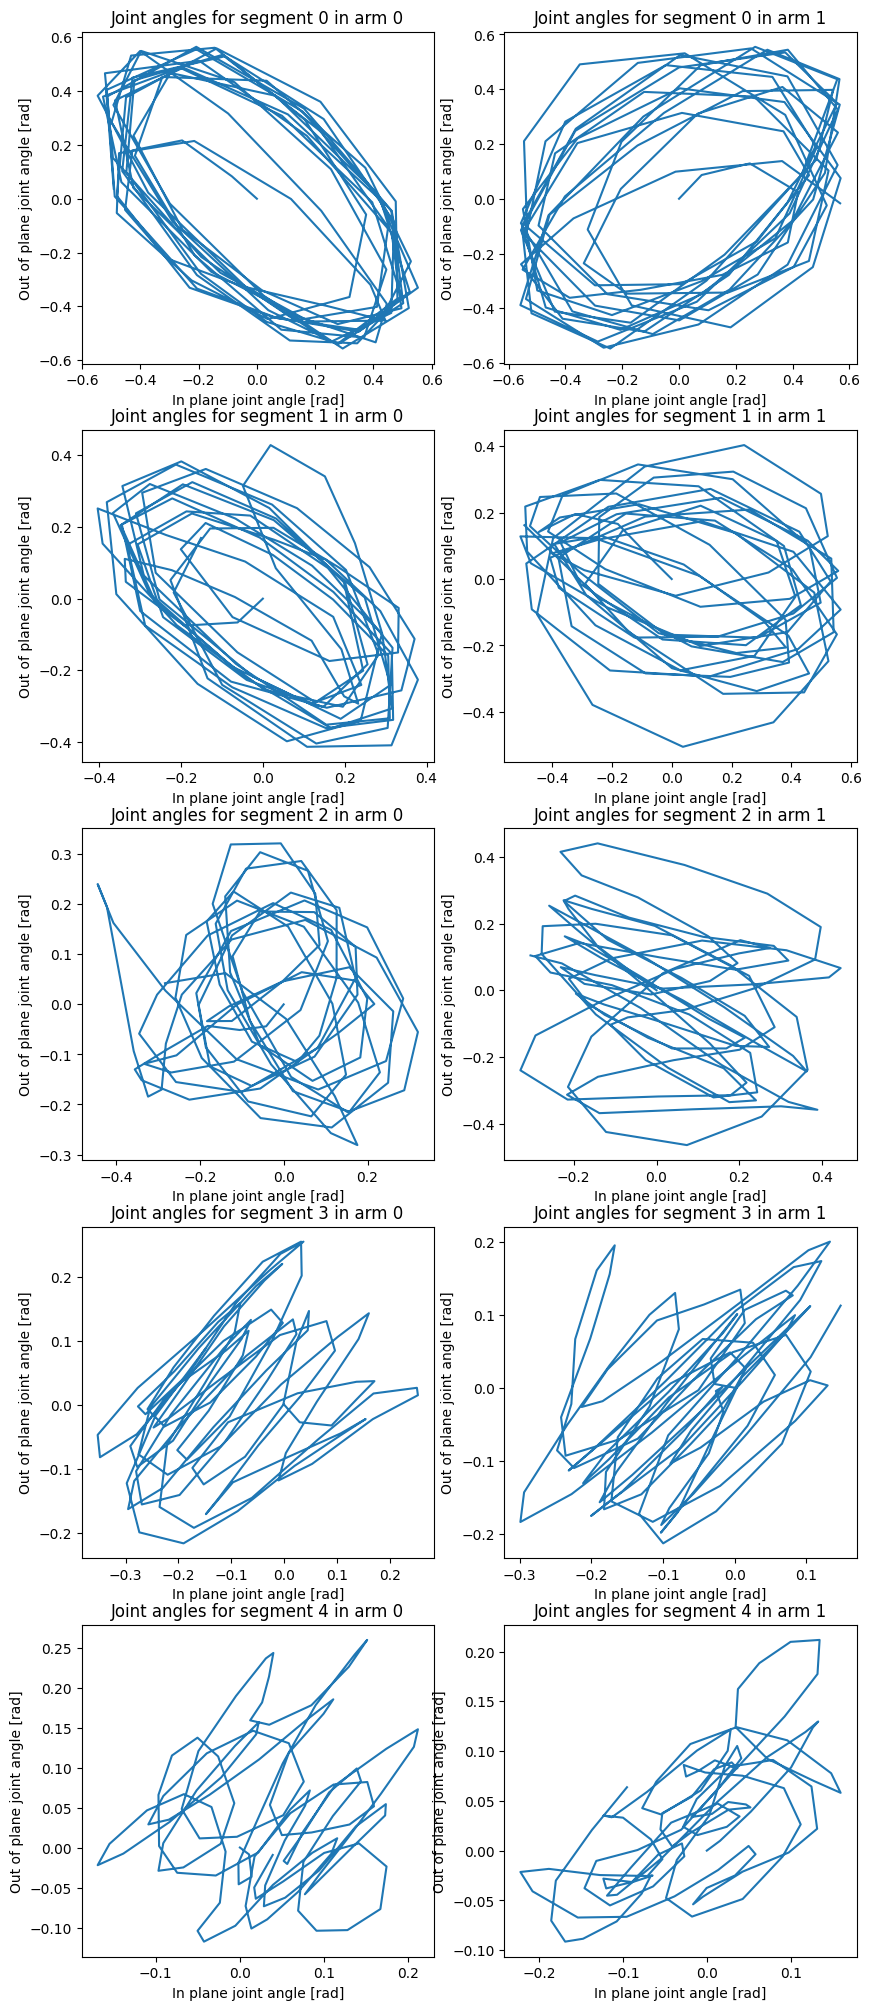

In [58]:
joint_angles_ip = np.array(joint_angles_ip)
joint_angles_oop = np.array(joint_angles_oop)
print(f"shape explanation: (t, number of arms, number of segment) = {joint_angles_ip.shape}")
t, num_arms, num_segments = joint_angles_ip.shape


plt.rcParams['figure.figsize'] = (5*num_arms,5*num_segments)



fig, axes = plt.subplots(num_segments,num_arms)


for i in range(num_segments):
    for j in range(num_arms):

        axes[i][j].plot(joint_angles_ip[:,j,i], joint_angles_oop[:,j,i])
        axes[i][j].set_title(f"Joint angles for segment {i} in arm {j}")
        axes[i][j].set_xlabel("In plane joint angle [rad]")
        axes[i][j].set_ylabel("Out of plane joint angle [rad]")
    
# plt.savefig('distance position arms 55555 popsize 400 (distance 4.5).jpg') # --> rather put it in wandb as a plot
wandb.log({"Joint Angles trained model": wandb.Image(fig)})
plt.show()


In [59]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


max reward,▁▂▄▅▇▇▆▆▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█
mean reward,▁▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
max reward,3.69513
mean reward,2.19008


In [ ]:
rng, env_rng, action_rng = jax.random.split(rng, 3)

jit_step = jax.jit(env.step)
jit_reset = jax.jit(env.reset)

env_state = jit_reset(rng=env_rng)

env_frames = []
while not (env_state.terminated | env_state.truncated):
    action_rng, sub_rng = jax.random.split(action_rng, 2)
    action = env.action_space.sample(rng=sub_rng)

    env_state = jit_step(state=env_state, action=action)
    env_frames.append(post_render(env.render(state=env_state), env.environment_configuration))
show_video(images=env_frames)

In [ ]:
mjx_vectorized_state = mjx_vectorized_reset(rng=mjx_vectorized_env_rng)

mjx_frames = []
i = 0
while not jnp.any(mjx_vectorized_state.terminated | mjx_vectorized_state.truncated):
    i += 1
    print(i)
    mjx_action_rng, *sub_rngs = jnp.array(jax.random.split(mjx_action_rng, NUM_MJX_ENVIRONMENTS + 1))
    action = mjx_vectorized_action_sample(rng=jnp.array(sub_rngs))
    
    mjx_vectorized_state = mjx_vectorized_step(state=mjx_vectorized_state, action=action)
    mjx_frames.append(
            post_render(
                mjx_vectorized_env.render(state=mjx_vectorized_state),
                mjx_vectorized_env.environment_configuration
                )
            )
show_video(images=mjx_frames)

In [ ]:
print("Observation space:")
print(f"\t{mjx_vectorized_env.observation_space}")
print("Action space:")
print(f"\t{mjx_vectorized_env.action_space}")

In [37]:
mjx_vectorized_env.close()

In [301]:
def fun1(sensor_selection, mjx_vectorized_state):
    sensory_input_nn = []
    for sensor in sensor_selection:
        sensory_input_nn.append(mjx_vectorized_state.observations[sensor])
    sensory_input_nn = jnp.concatenate(sensory_input_nn, axis = 1)
    return sensory_input_nn

def fun2(senfor_selection, mjx_vectorized_state):
    sensory_input_nn = jnp.concatenate(
        jax.tree_util.tree_map(mjx_vectorized_state.observations.__getitem__, sensor_selection),
        axis = 1
    )
    return sensory_input_nn

sensory_input_nn_1 = fun1(sensor_selection, mjx_vectorized_state)
sensory_input_nn_2 = fun2(sensor_selection, mjx_vectorized_state)
print(sensory_input_nn_1 - sensory_input_nn_2)

print(jax.make_jaxpr(fun1, static_argnums=0)(sensor_selection, mjx_vectorized_state))
print()
print(jax.make_jaxpr(fun2, static_argnums=0)(sensor_selection, mjx_vectorized_state))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{ lambda ; a:f32[300,3] b:f32[300,3] c:f32[300,3] d:f32[300,3] e:f32[300,10] f:f32[300,10]
    g:f32[300,10] h:f32[300,10] i:i32[300,10] j:f32[300] k:bool[300] l:bool[300]
    m:f32[300] n:f32[300] o:u32[300,2] p:f32[300] q:f32[300] r:f32[300] s:f32[300,3]
    t:f32[300,3] u:f32[300] v:f32[300] w:f32[300] x:f32[300,27] y:f32[300,27] z:f32[300,18,3]
    ba:f32[300,18,4] bb:f32[300,18,3] bc:f32[300,18,4] bd:f32[300,18] be:f32[300,18]
    bf:f32[300,18,3] bg:f32[300,18,2] bh:f32[300,21,2] bi:f32[300,21,5] bj:f32[300,21,3]
    bk:f32[300,21,3] bl:f32[300,21] bm:f32[300,21,2] bn:f32[300,21,2] bo:f32[300,21]
    bp:f32[300,26,2] bq:f32[300,26,5] br:f32[300,26] bs:f32[300,26] bt:f32[300,26]
    bu:f32[300,26] bv:f32[300,26] bw:f32[300,36] bx:f32[300,36,2] by:f32[300,36,5]
    bz:f32[300,36,3] ca:f32[300,36,3] cb:f32[300,36,4] cc:f32[300,36

TypeError: unsupported operand type(s) for -: 'ClosedJaxpr' and 'ClosedJaxpr'

## Trying to implement cumsum with jax.lax.scan

In [33]:
a = np.array([1, 2, 3, 5, 7, 11, 13, 17])

In [36]:
def cumsum(input_array):
    carry_init = 0
    def step(carry, el):
        carry += el
        return carry, carry # add the elements to the stack output --> will be cumsum list

    state, output_stack = jax.lax.scan(
        step,
        carry_init,
        input_array,
    )

    return output_stack

    

In [37]:
print(cumsum(a))

[ 1  3  6 11 18 29 42 59]


In [42]:
result = []
res = 0
for el in a:
    res += el
    result.append(res)

np.array(result)
print(result)

[1, 3, 6, 11, 18, 29, 42, 59]


In [39]:
def cumsum(a):
    carry_init = 0
    def step(carry, el):
        carry = carry + el
        return carry, carry

    _, cumsum_array = jax.lax.scan(
        step,
        carry_init,
        a
    )
    return cumsum_array
    

In [43]:
print(a)
print(cumsum(a))

[ 1  2  3  5  7 11 13 17]
[ 1  3  6 11 18 29 42 59]


Exercise wealth compound interest

In [49]:
wealth_record = []
starting_wealth = 100.0
interest_factor = 1.01
num_timesteps = 100
prev_wealth = starting_wealth

for t in range(num_timesteps):
    new_wealth = prev_wealth * interest_factor
    wealth_record.append(prev_wealth)
    prev_wealth = new_wealth

wealth_record = np.array(wealth_record)

In [50]:
wealth_1 = wealth_record

In [52]:
def wealth(starting_wealth, num_timesteps, interest_factor):
    def step(carry, xs):
        current_wealth, interest_factor = carry
        new_wealth = current_wealth * interest_factor
        return [new_wealth, interest_factor], current_wealth

    _, wealth_record = jax.lax.scan(
        step,
        [starting_wealth, interest_factor],
        None,
        num_timesteps
    )
    return wealth_record

wealth_2 = wealth(starting_wealth, num_timesteps, interest_factor)

In [54]:
print(wealth_1 - wealth_2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
